# Package and data

In [1]:
## package and data
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
import joblib
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import shap
from PyALE import ale
import seaborn as sns

In [2]:
## all information for multiple years and multiple locations
all_info = pd.read_csv('result/all_info.csv')

In [3]:
## change location and road class to dummy variables with one hot encoding
all_info = pd.get_dummies(all_info, columns = ['location', 'roadclass'])

In [5]:
## select observations for all-year, one-year, two-year, three-year, and four-year models
def pre_data(n):
    X=all_info
    if(n==0):
        Xs=X
    elif(n<4):
        upper = n*365
        down = (n-1)*365
        Xs = X[(X['DiffDay']<=upper) & (X['DiffDay']>down)]
    else:
        down = (n-1)*365
        Xs = X[X['DiffDay']>down]

    return(Xs)

# Perfomance comparison

## All year rating

### Variable contribution

In [6]:
all_year_rating_hgbm= joblib.load('result/all_year_rating_hgbm.sav')

In [7]:
Xs = pre_data(0)
X = Xs.drop(columns=['rating2', 'DiffRating'])
y = Xs['rating2']

In [8]:
feature_names = ['Current PCR', 'Maximum temperature', 'Minimum temperature', 'Average temperature', 'Total precipitation', 'Wind speed',
       'Frozen days', 'Hot days', 'Windy days', 'Freeze thaw cycles', 'Employment density', 'Land use mix',
       'Network density', 'Job accessibility', 'Total population', 'Change of total population', 'Car to work percentage',
       'Change of car to work percentage', 'Labor percentage', 'Change to labor percentage', 'Median household income', 'Change of income', 'Number of days',
       'location_alma', 'location_cumberland', 'location_dormont',
       'location_longboat', 'location_robinson', 'location_sedona',
       'location_shaler', 'location_southbend', 'location_upperstclair',
       'Local or other road', 'roadclass_Primary', 'roadclass_Secondary']

In [9]:
all_year_rating_hgbm= joblib.load('result/all_year_rating_hgbm.sav')
explainer = shap.Explainer(all_year_rating_hgbm)
shap_values = explainer.shap_values(X)

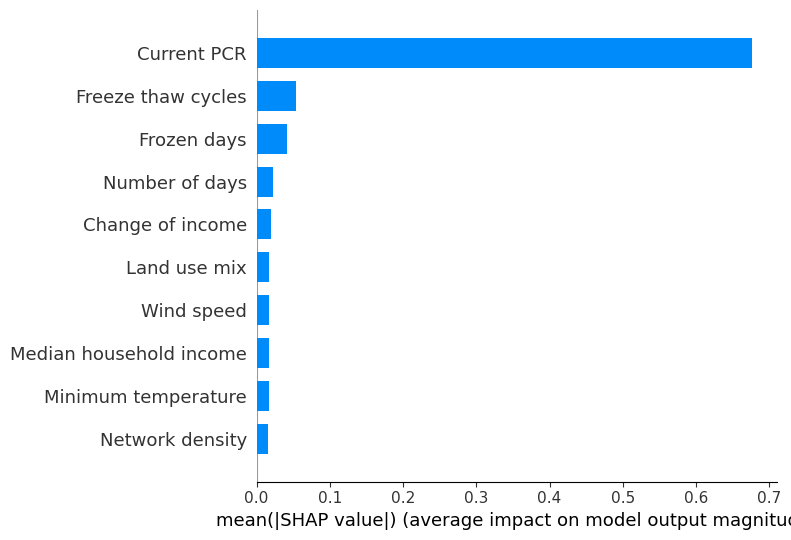

In [10]:
shap.summary_plot(shap_values, X, feature_names=feature_names, max_display=10, plot_type='bar')
plt.show()

In [11]:
# Calculate the mean of the absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Pair the feature names with their respective mean absolute SHAP values
feature_shap_pairs = list(zip(feature_names, mean_abs_shap_values))

# Sort the pairs in descending order based on the mean absolute SHAP values
sorted_feature_shap_pairs = sorted(feature_shap_pairs, key=lambda x: x[1], reverse=True)

# Print the sorted feature names and their mean absolute SHAP values
for feature, shap_value in sorted_feature_shap_pairs:
    print(f"{feature}: {round(shap_value, 4)}")

Current PCR: 0.6764
Freeze thaw cycles: 0.0541
Frozen days: 0.0416
Number of days: 0.0221
Change of income: 0.0194
Land use mix: 0.0174
Wind speed: 0.017
Median household income: 0.0168
Minimum temperature: 0.0165
Network density: 0.0151
Local or other road: 0.0145
Employment density: 0.0144
Job accessibility: 0.0131
Total population: 0.0122
Labor percentage: 0.0106
Change of total population: 0.0106
Total precipitation: 0.0103
Change of car to work percentage: 0.0102
Car to work percentage: 0.0087
Average temperature: 0.0083
Change to labor percentage: 0.0081
Maximum temperature: 0.008
Windy days: 0.0071
location_shaler: 0.0052
Hot days: 0.0049
roadclass_Secondary: 0.0022
location_robinson: 0.0007
roadclass_Primary: 0.0004
location_alma: 0.0
location_cumberland: 0.0
location_dormont: 0.0
location_longboat: 0.0
location_sedona: 0.0
location_southbend: 0.0
location_upperstclair: 0.0


## All year rating difference

### Variable contribution

In [17]:
Xs = pre_data(0)
X = Xs.drop(columns=['rating2', 'DiffRating'])
y = Xs['DiffRating']

In [18]:
all_year_rating_difference_hgbm= joblib.load('result/all_year_rating_difference_hgbm.sav')
explainer = shap.Explainer(all_year_rating_difference_hgbm)
shap_values = explainer.shap_values(X)

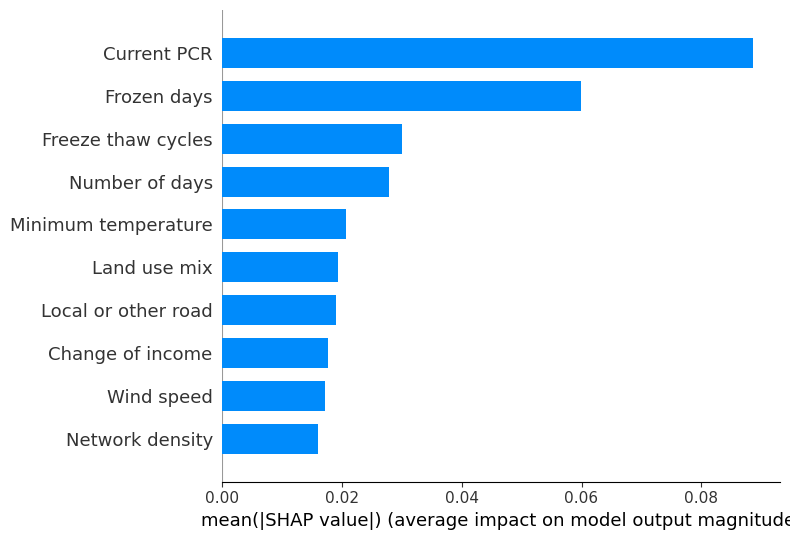

In [19]:
shap.summary_plot(shap_values, X, feature_names=feature_names, max_display=10, plot_type='bar')
plt.show()

In [20]:
# Calculate the mean of the absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Pair the feature names with their respective mean absolute SHAP values
feature_shap_pairs = list(zip(feature_names, mean_abs_shap_values))

# Sort the pairs in descending order based on the mean absolute SHAP values
sorted_feature_shap_pairs = sorted(feature_shap_pairs, key=lambda x: x[1], reverse=True)

# Print the sorted feature names and their mean absolute SHAP values
for feature, shap_value in sorted_feature_shap_pairs:
    print(f"{feature}: {round(shap_value, 3)}")

Current PCR: 0.089
Frozen days: 0.06
Freeze thaw cycles: 0.03
Number of days: 0.028
Minimum temperature: 0.021
Land use mix: 0.019
Local or other road: 0.019
Change of income: 0.018
Wind speed: 0.017
Network density: 0.016
Employment density: 0.015
Job accessibility: 0.014
Median household income: 0.013
Total population: 0.013
Change of total population: 0.012
Labor percentage: 0.011
Car to work percentage: 0.01
Change to labor percentage: 0.01
Maximum temperature: 0.009
Change of car to work percentage: 0.008
Total precipitation: 0.007
Average temperature: 0.006
Windy days: 0.005
Hot days: 0.003
location_shaler: 0.003
location_dormont: 0.001
roadclass_Secondary: 0.001
location_robinson: 0.0
roadclass_Primary: 0.0
location_alma: 0.0
location_cumberland: 0.0
location_longboat: 0.0
location_sedona: 0.0
location_southbend: 0.0
location_upperstclair: 0.0


### ALE

In [25]:
def plot_1d_ale(var, var_name, subplot_index):
    p = ale(X, all_year_rating_difference_hgbm, feature=[var], grid_size=50, feature_type='continuous')
    plt.close()
    ## redesign data
    XX = list(p.index)
    YY = p['eff']
    ## plot
    ax = fig.add_subplot(2, 4, subplot_index)
    ax.plot(XX, YY)
    ax.set_ylim(-0.7, 0.3)
    sns.rugplot(data=X, x=var, alpha=0.01, color='black', ax=ax)
    ax.set_xlabel(var_name)
    ax.set_ylabel('Effect (centered)')

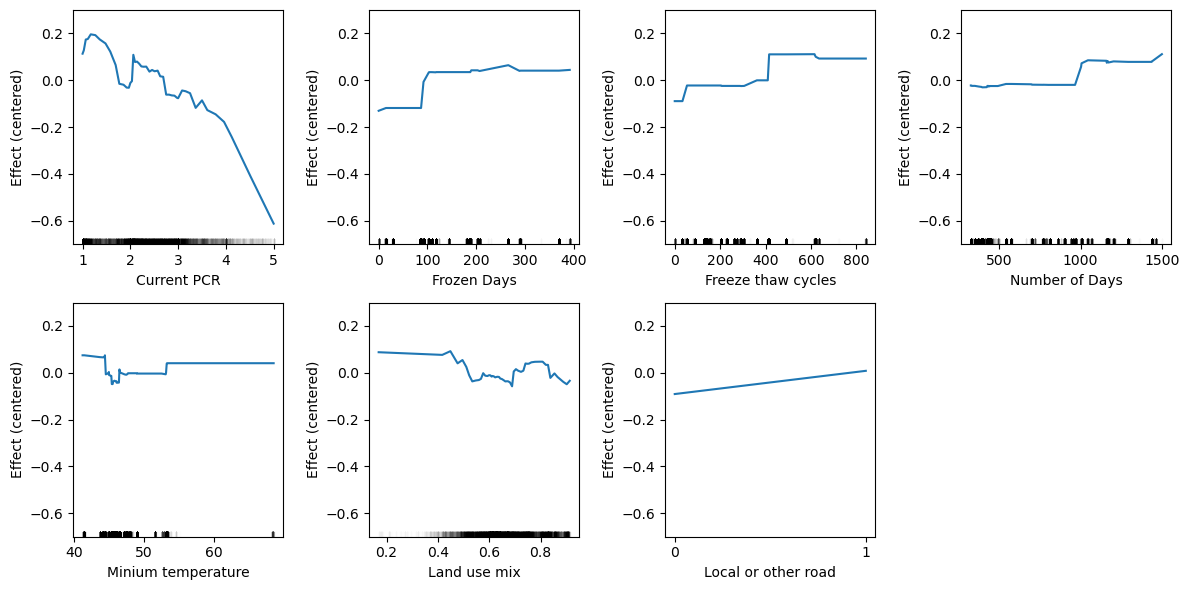

In [26]:
fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(6)

plot_1d_ale('rating1', 'Current PCR', 1)

plot_1d_ale('FrozenDays', 'Frozen Days', 2)

plot_1d_ale('FTC', 'Freeze thaw cycles', 3)

plot_1d_ale('DiffDay', 'Number of Days', 4)

plot_1d_ale('MinTemp', 'Minium temperature', 5)

plot_1d_ale('LandMix', 'Land use mix', 6)

p = ale(
    X=X,
    model=all_year_rating_difference_hgbm,
    feature=['roadclass_Local or other'],
    feature_type="discrete"
)
plt.close()
XX = list(p.index)
YY = p['eff']
ax = fig.add_subplot(2, 4, 7)
ax.plot(XX, YY, )
ax.set_ylim(-0.7, 0.3)
ax.set_xticks(ticks=[0,1])
ax.set_xlabel('Local or other road')
ax.set_ylabel('Effect (centered)')

plt.tight_layout()

plt.show()

In [27]:
def plot_2d_ale(var, var_name, subplot_index):
    features=[var, 'rating1']
    ## generate the data
    p = ale(X, all_year_rating_difference_hgbm, feature=features,
            grid_size=50)
    plt.close()

    ## redesign data
    XX = np.array(list(p.columns))
    YY = np.array(list(p.index))
    XX, YY = np.meshgrid(XX, YY)
    Z = np.array(p.values)

    ## plot results
    ax = fig.add_subplot(subplot_index, projection='3d')
    surf = ax.plot_surface(XX, YY, Z, cmap='bwr', vmin=-0.3, vmax=0.3)
    ax.set_zlim(-0.3, 0.3)
    ax.set_xlabel('Current PCR')
    ax.set_ylabel(var_name)
    ax.view_init(elev=30, azim=-45)

    clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
    clb.ax.set_title('Effect')

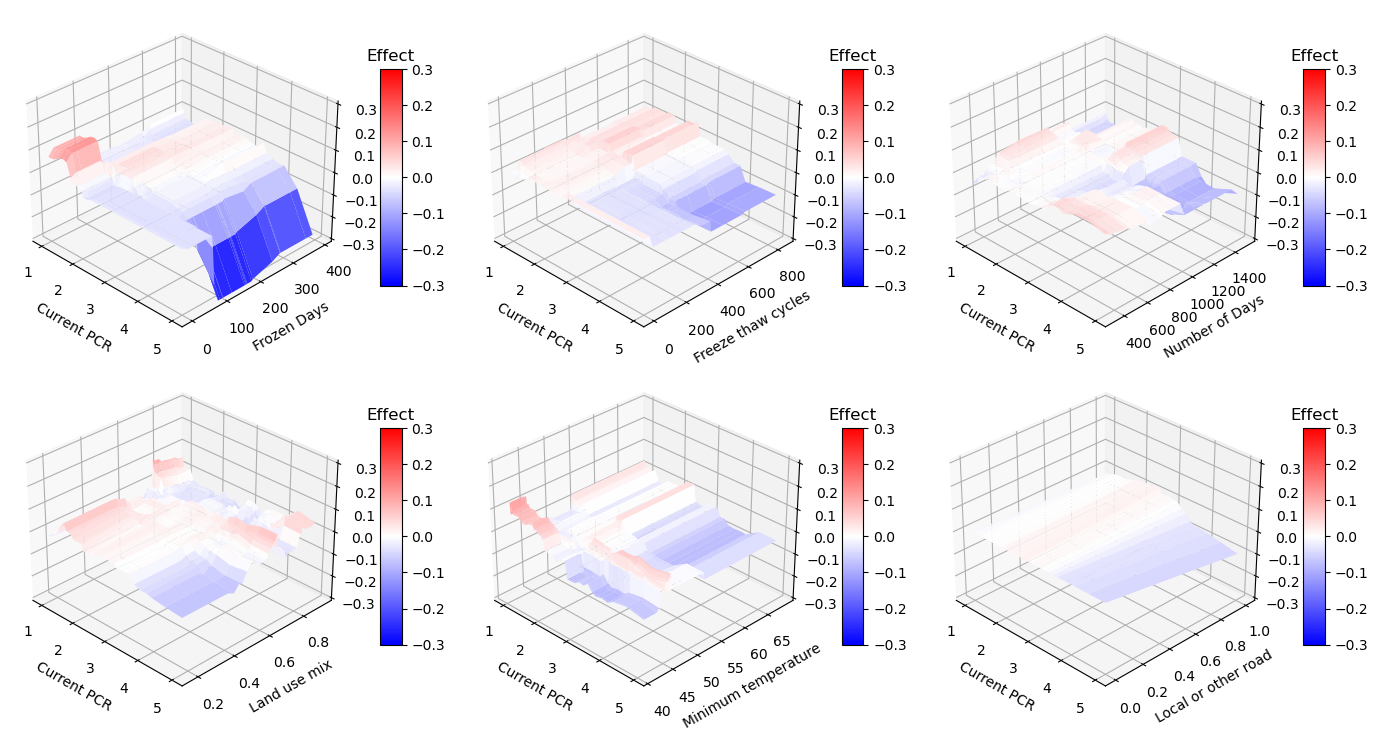

In [28]:
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(7.5)

plot_2d_ale('FrozenDays', 'Frozen Days', 231)

plot_2d_ale('FTC', 'Freeze thaw cycles', 232)

plot_2d_ale('DiffDay', 'Number of Days', 233)

plot_2d_ale('LandMix', 'Land use mix', 234)

plot_2d_ale('MinTemp', 'Minimum temperature', 235)

plot_2d_ale('roadclass_Local or other', 'Local or other road', 236)

plt.tight_layout()

plt.show()

# Mapping the errors

Use Dormont as an example

## PCR change model

In [29]:
## import the shapefile of Dormont
dormont = gpd.read_file('result/dormont_segment.shp')

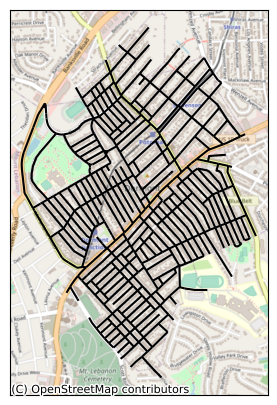

In [30]:
## plot with base map
ax = dormont.plot(figsize=(5, 5), color='black')
ax.set_xticks([])
ax.set_yticks([])
cx.add_basemap(ax, zoom = 15, crs=dormont.crs, source=cx.providers.OpenStreetMap.Mapnik)

In [31]:
(xmin, ymin, xmax, ymax) = dormont.total_bounds

In [32]:
all_info['date1'] = pd.to_datetime(all_info['date1'])
all_info['date2'] = pd.to_datetime(all_info['date2'])
y_pred = all_year_rating_difference_hgbm.predict(X)
all_info['DiffRating_pred'] = y_pred

In [33]:
all_info['error'] = all_info['DiffRating_pred']-all_info['DiffRating']

In [35]:
def plot_dormont(year1, year2, subplot_index):
    df = all_info[(all_info['date1'].dt.year==year1) & (all_info['date2'].dt.year==year2) & (all_info['location_dormont']==1)][['segID', 'error']]
    gpd_df = pd.merge(dormont, df, on='segID', how='left')

    ## plot results
    ax = fig.add_subplot(subplot_index)
    gpd_df.plot(column='error', cmap='RdYlGn', legend = True, vmin=-1, vmax=1, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(xmin-100, xmax+100)
    ax.set_ylim(ymin-100, ymax+100)
    ax.set_title(str(year1)+'->'+str(year2))

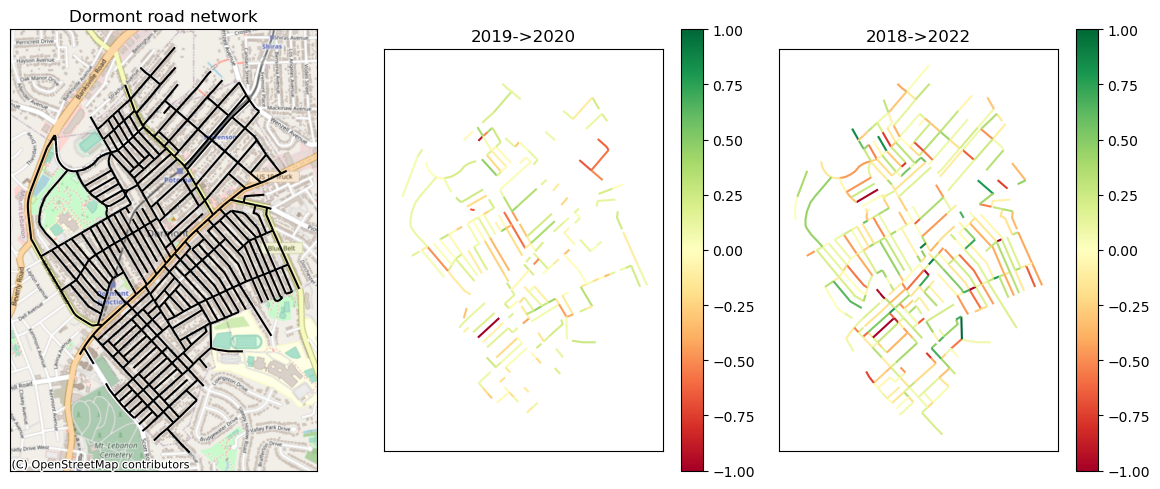

In [36]:
fig = plt.figure()
# fig.set_figwidth(12)
# fig.set_figheight(14)
fig.set_figwidth(12)
fig.set_figheight(5)

ax = fig.add_subplot(131)
dormont.plot(color='black', ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(xmin-100, xmax+100)
ax.set_ylim(ymin-100, ymax+100)
ax.set_title('Dormont road network')
cx.add_basemap(ax, zoom = 15, crs=dormont.crs, source=cx.providers.OpenStreetMap.Mapnik)

plot_dormont(2019, 2020, 132)

plot_dormont(2018, 2022, 133)

plt.tight_layout()
plt.show()

## PCR model

In [39]:
y_pred = all_year_rating_hgbm.predict(X)
all_info['Rating_pred'] = y_pred

In [40]:
all_info['Rating_error'] = all_info['Rating_pred']-all_info['rating2']

In [41]:
def plot_dormont(year1, year2, subplot_index):
    df = all_info[(all_info['date1'].dt.year==year1) & (all_info['date2'].dt.year==year2) & (all_info['location_dormont']==1)][['segID', 'Rating_error']]
    gpd_df = pd.merge(dormont, df, on='segID', how='left')

    ## plot results
    ax = fig.add_subplot(subplot_index)
    gpd_df.plot(column='Rating_error', cmap='RdYlGn', legend = True, vmin=-1.7, vmax=1.7, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(xmin-100, xmax+100)
    ax.set_ylim(ymin-100, ymax+100)
    ax.set_title(str(year1)+'->'+str(year2))

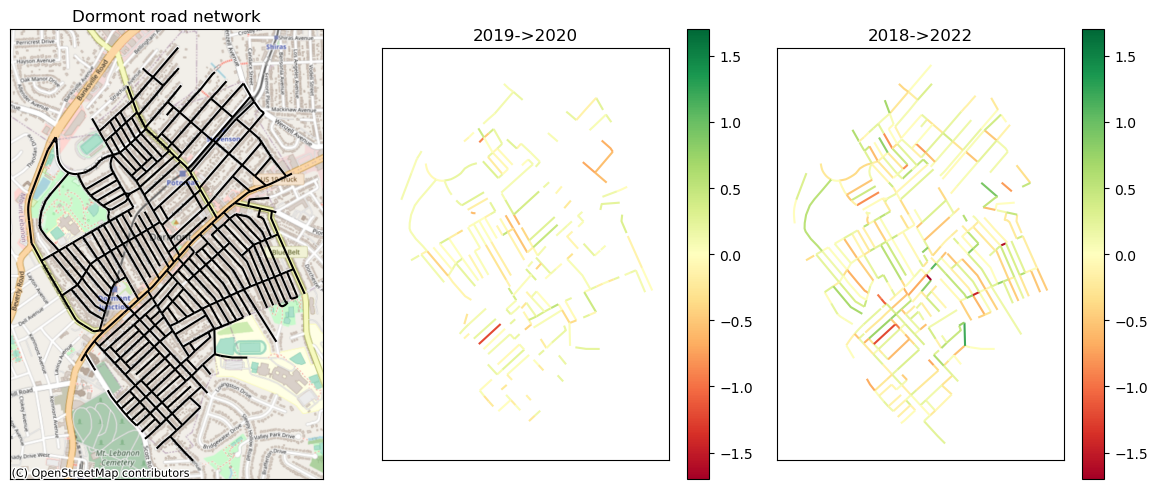

In [42]:
fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(5)

ax = fig.add_subplot(131)
dormont.plot(color='black', ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(xmin-100, xmax+100)
ax.set_ylim(ymin-100, ymax+100)
ax.set_title('Dormont road network')
cx.add_basemap(ax, zoom = 15, crs=dormont.crs, source=cx.providers.OpenStreetMap.Mapnik)

plot_dormont(2019, 2020, 132)
plot_dormont(2018, 2022, 133)

plt.tight_layout()
plt.show()